# Feature engineering

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../../../utils/Python/setup_environment.ipy
%run ../../../utils/Python/selene_job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [35]:
# model_RF = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
#                          RandomForestClassifier(random_state=42, criterion='entropy', max_depth=20, n_estimators=500))

# Get the data

In [36]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact')
data.impact.shape

(194211, 65)

In [5]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_SYMBOL', 'VEP_VARIANT_CLASS'],

    'freq': ['frequency_in_normals'],

    'somatic-driver': ['VEP_COSMIC_CNT',
                       'is_a_hotspot', 'is_a_3d_hotspot', 'oncogenic'],

    'consequence': ['gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'Kaviar_AF', 'VEP_in_dbSNP'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = unlist([group for key, group in features_groups.items() if key not in groups_to_remove])
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove unique values
    return list(set(final_selection))

# Baseline

In [5]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_baseline = Selene_Job('fe_baseline', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
job_baseline.load_data(X, y)

<span style="color:red">Job < fe_baseline >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_baseline


<span style="color:green">Job < fe_baseline >: </span>✅ data loaded

In [2]:
job_baseline = Selene_Job('fe_baseline', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_baseline >: </span>✅ job found and reloaded

In [7]:
%%writefile {job_baseline.script_path}

# load the ml_tools functions
%run ../../../../../utils/Python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# set cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=500))
metrics = Metrics(model, X, y, cv_strategy, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_fe_baseline/script.ipy


In [8]:
job_baseline.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_fe_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_baseline
script.ipy                                    100%  863     4.3KB/s   00:00    
X.pkl                                         100%   64MB   5.8MB/s   00:11    
y.pkl                                         100% 3225KB   3.1MB/s   00:01    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_baseline
Job <30437759> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_baseline -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_baseline >: </span>✅ submitted<br>

In [3]:
job_baseline.get_results()

<span style="color:green">Job < fe_baseline >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_baseline to ssh_remote_jobs/job_fe_baseline
metrics.pkl                                   100%   64MB   9.0MB/s   00:07    
job_output.txt                                100% 1517   509.1KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.603 ± 0.012
▴ Mean roc_auc          : 0.909 ± 0.004
▴ Mean precision        : 0.206 ± 0.004
▴ Mean recall           : 0.786 ± 0.012
▴ Mean f1               : 0.327 ± 0.005
▴ Mean accuracy         : 0.880 ± 0.003


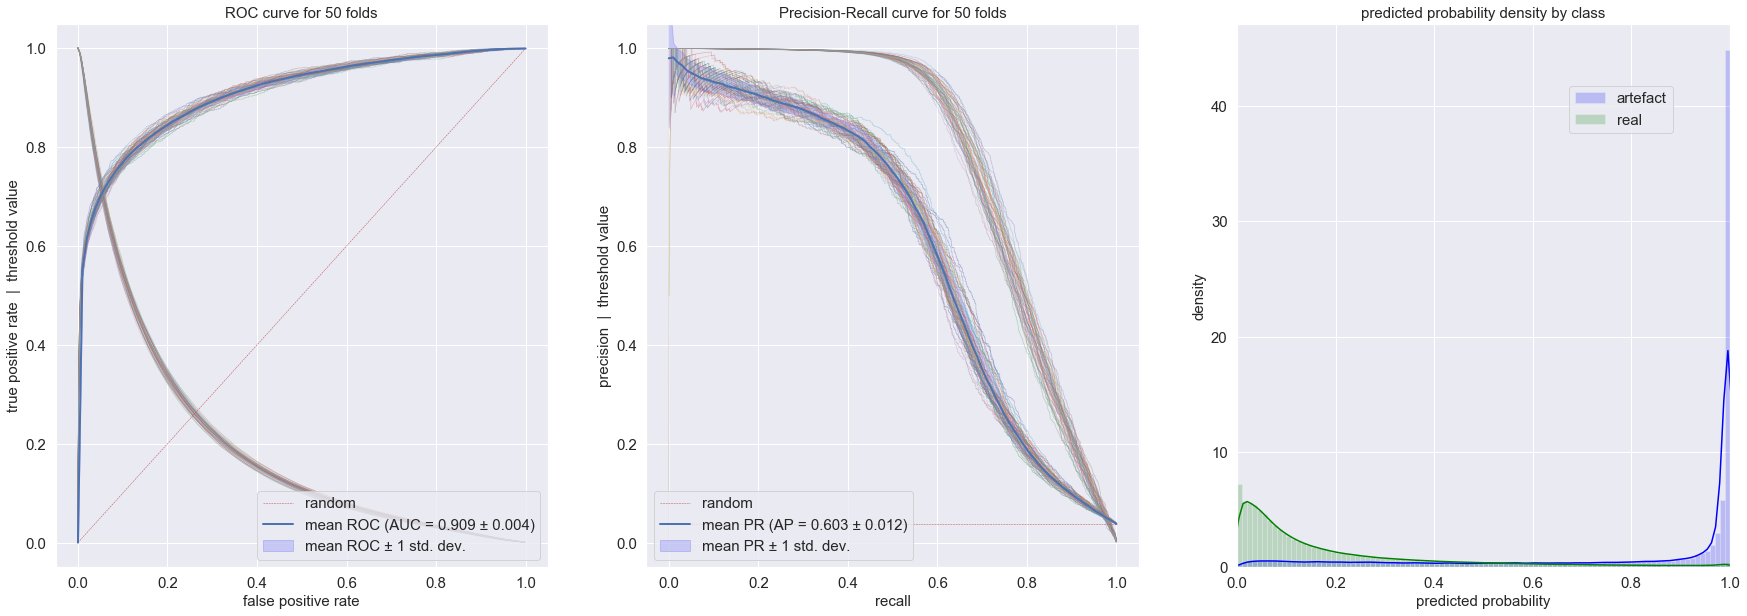

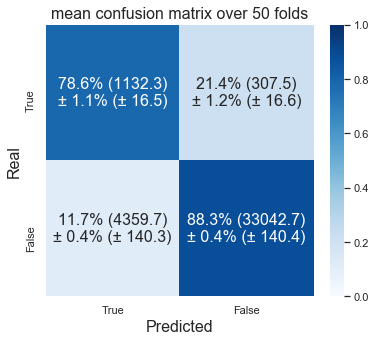

In [9]:
job_baseline.metrics.print_mean()
job_baseline.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_baseline.metrics.plot_mean_confusion_matrix()

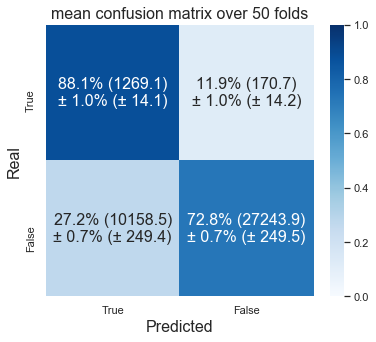

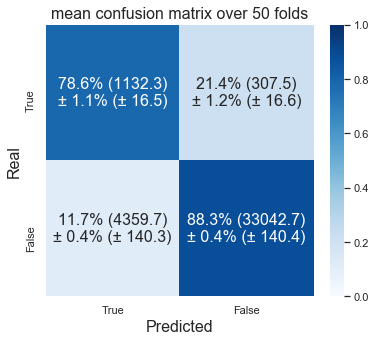

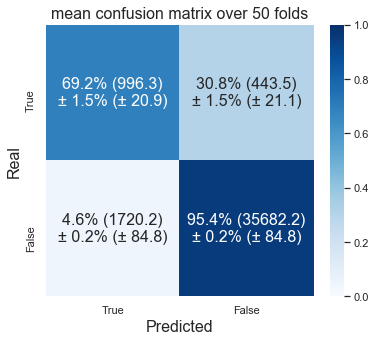

In [10]:
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.25)
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.5)
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.75)

# Removing one group

In [11]:
job_list = {}

for group in features_groups.keys():
    name = 'without_{}'.format(group)
    print_md('**{}**'.format(name))
    
    job_list[name] = Selene_Job('fe_{}'.format(name), 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
    
    # get X and y
    print('Get X and y...', end= '')
    start = time.time()
    features = get_features(groups_to_remove = [group], individual_features_to_remove = ['VEP_SYMBOL'])
    X, y = data.process(features).get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} raw features, {} features after processing)'.format(time.time() - start, len(features), X.shape[1]))
    
    # prepare job
    job_list[name].load_data(X, y, path_to_script=job_baseline.script_path)

**without_NGS**

<span style="color:red">Job < fe_without_NGS >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (8.16s, 25 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_without_NGS


<span style="color:green">Job < fe_without_NGS >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_without_NGS


<span style="color:green">Job < fe_without_NGS >: </span>✅ script loaded

**without_genome**

<span style="color:red">Job < fe_without_genome >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (7.52s, 34 raw features, 63 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_without_genome


<span style="color:green">Job < fe_without_genome >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_without_genome


<span style="color:green">Job < fe_without_genome >: </span>✅ script loaded

**without_freq**

<span style="color:red">Job < fe_without_freq >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (9.13s, 35 raw features, 90 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_without_freq


<span style="color:green">Job < fe_without_freq >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_without_freq


<span style="color:green">Job < fe_without_freq >: </span>✅ script loaded

**without_somatic-driver**

<span style="color:red">Job < fe_without_somatic-driver >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (6.64s, 32 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_without_somatic-driver


<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_without_somatic-driver


<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ script loaded

**without_consequence**

<span style="color:red">Job < fe_without_consequence >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (5.40s, 30 raw features, 64 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_without_consequence


<span style="color:green">Job < fe_without_consequence >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_without_consequence


<span style="color:green">Job < fe_without_consequence >: </span>✅ script loaded

**without_AF**

<span style="color:red">Job < fe_without_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (7.98s, 24 raw features, 78 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_without_AF


<span style="color:green">Job < fe_without_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_without_AF


<span style="color:green">Job < fe_without_AF >: </span>✅ script loaded

In [6]:
job_list = {}
for group in features_groups.keys():
    name = 'without_{}'.format(group)
    job_list[name] = Selene_Job('fe_{}'.format(name), 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id='True')

<span style="color:green">Job < fe_without_NGS >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_genome >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_freq >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_consequence >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_AF >: </span>✅ job found and reloaded

In [14]:
for job in job_list.values():
    print_md('**{}**'.format(job.job_id))
    job.run(n_jobs=20, short_job=True)

**fe_without_NGS**

➞ scp ssh_remote_jobs/job_fe_without_NGS to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_NGS
script.ipy                                    100%  863    45.5KB/s   00:00    
X.pkl                                         100%   47MB  15.8MB/s   00:03    
y.pkl                                         100% 3225KB  10.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_NGS
Job <30437805> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_NGS -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_NGS >: </span>✅ submitted<br>

**fe_without_genome**

➞ scp ssh_remote_jobs/job_fe_without_genome to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_genome
script.ipy                                    100%  863    26.3KB/s   00:00    
X.pkl                                         100%   59MB  14.8MB/s   00:04    
y.pkl                                         100% 3225KB   7.7MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_genome
Job <30437806> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_genome -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_genome >: </span>✅ submitted<br>

**fe_without_freq**

➞ scp ssh_remote_jobs/job_fe_without_freq to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_freq
script.ipy                                    100%  863    11.1KB/s   00:00    
X.pkl                                         100%   62MB  15.5MB/s   00:04    
y.pkl                                         100% 3225KB   9.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_freq
Job <30437808> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_freq -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_freq >: </span>✅ submitted<br>

**fe_without_somatic-driver**

➞ scp ssh_remote_jobs/job_fe_without_somatic-driver to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_somatic-driver
script.ipy                                    100%  863    20.6KB/s   00:00    
X.pkl                                         100%   56MB  11.1MB/s   00:05    
y.pkl                                         100% 3225KB  10.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_somatic-driver
Job <30437809> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_somatic-driver -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ submitted<br>

**fe_without_consequence**

➞ scp ssh_remote_jobs/job_fe_without_consequence to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_consequence
script.ipy                                    100%  863    28.7KB/s   00:00    
X.pkl                                         100%   50MB  12.6MB/s   00:04    
y.pkl                                         100% 3225KB  11.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_consequence
Job <30437810> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_consequence -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_consequence >: </span>✅ submitted<br>

**fe_without_AF**

➞ scp ssh_remote_jobs/job_fe_without_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_AF
script.ipy                                    100%  863    80.4KB/s   00:00    
X.pkl                                         100%   45MB   9.0MB/s   00:05    
y.pkl                                         100% 3225KB   8.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_AF
Job <30437816> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_AF >: </span>✅ submitted<br>

In [7]:
for job in job_list.values():
    print_md('**{}**'.format(job.job_id))
    job.get_results()

**fe_without_NGS**

<span style="color:green">Job < fe_without_NGS >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_NGS to ssh_remote_jobs/job_fe_without_NGS
metrics.pkl                                   100%   39MB   9.1MB/s   00:04    
job_output.txt                                100% 1407   223.6KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_genome**

<span style="color:green">Job < fe_without_genome >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_genome to ssh_remote_jobs/job_fe_without_genome
metrics.pkl                                   100%   64MB   9.1MB/s   00:07    
job_output.txt                                100% 1533   494.9KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_freq**

<span style="color:green">Job < fe_without_freq >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_freq to ssh_remote_jobs/job_fe_without_freq
metrics.pkl                                   100%   64MB   9.1MB/s   00:07    
job_output.txt                                100% 1528   362.2KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_somatic-driver**

<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_somatic-driver to ssh_remote_jobs/job_fe_without_somatic-driver
metrics.pkl                                   100%   64MB   9.4MB/s   00:06    
job_output.txt                                100% 1558   263.7KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_consequence**

<span style="color:green">Job < fe_without_consequence >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_consequence to ssh_remote_jobs/job_fe_without_consequence
metrics.pkl                                   100%   64MB  10.5MB/s   00:06    
job_output.txt                                100% 1433   401.8KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_AF**

<span style="color:green">Job < fe_without_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_AF to ssh_remote_jobs/job_fe_without_AF
metrics.pkl                                   100%   64MB  10.8MB/s   00:05    
job_output.txt                                100% 1522   365.7KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.327,0.88
without_NGS,0.523,0.874,0.161,0.734,0.263,0.848
without_genome,0.592,0.897,0.2,0.765,0.317,0.878
without_freq,0.588,0.905,0.197,0.782,0.314,0.873
without_somatic-driver,0.597,0.904,0.205,0.775,0.324,0.88
without_consequence,0.594,0.898,0.202,0.772,0.32,0.878
without_AF,0.509,0.892,0.165,0.778,0.273,0.846


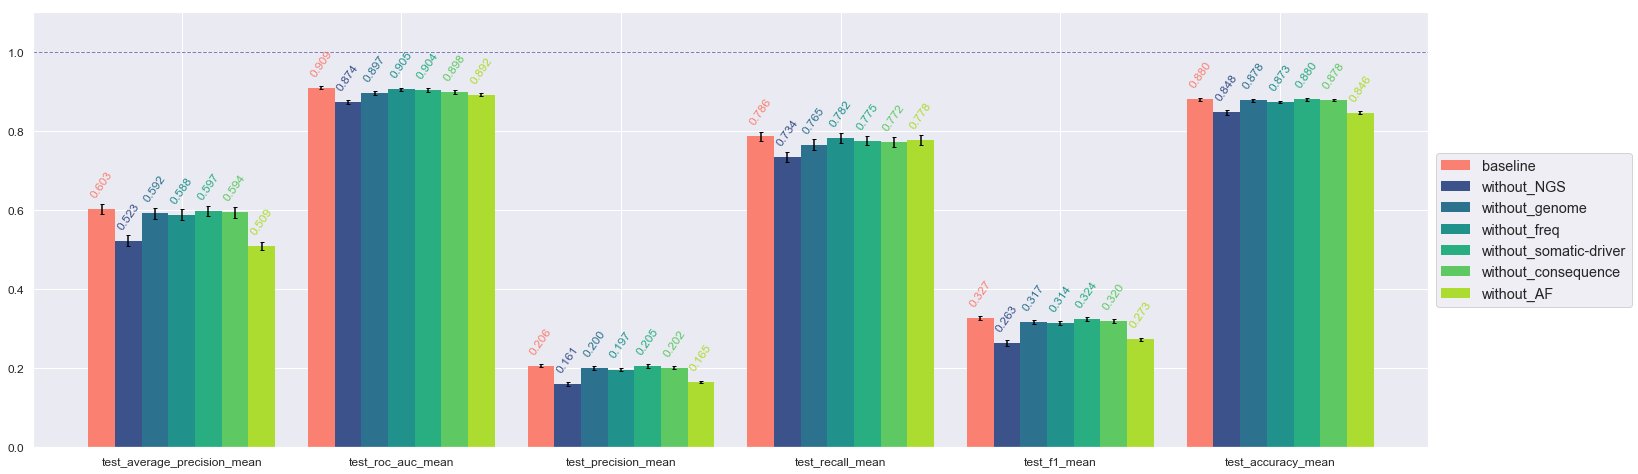

In [8]:
# create summary
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')

# fill summary
for key in job_list:
    summary.add(job_list[key].metrics, key)

# save summary
summary.save('summaries/fe_removing_groups_one_by_one.pkl')

# plot summary
summary.display()
summary.plot()

# Without gnomAD populations

In [16]:
features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_without_gnomAD_populations', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_baseline.script_path)

➞ mkdir on local computer ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

In [9]:
job = Selene_Job('fe_without_gnomAD_populations', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ job found and reloaded

In [18]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_fe_without_gnomAD_populations to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_gnomAD_populations
script.ipy                                    100%  863    45.5KB/s   00:00    
X.pkl                                         100%   53MB  10.7MB/s   00:05    
y.pkl                                         100% 3225KB   6.9MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_gnomAD_populations
Job <30437821> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_gnomAD_populations -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ submitted<br>

In [10]:
job.get_results()

<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_gnomAD_populations to ssh_remote_jobs/job_fe_without_gnomAD_populations
metrics.pkl                                   100%   64MB   9.8MB/s   00:06    
job_output.txt                                100% 1571   513.3KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.327,0.88
fe_without_gnomAD_populations,0.6,0.909,0.206,0.787,0.326,0.879


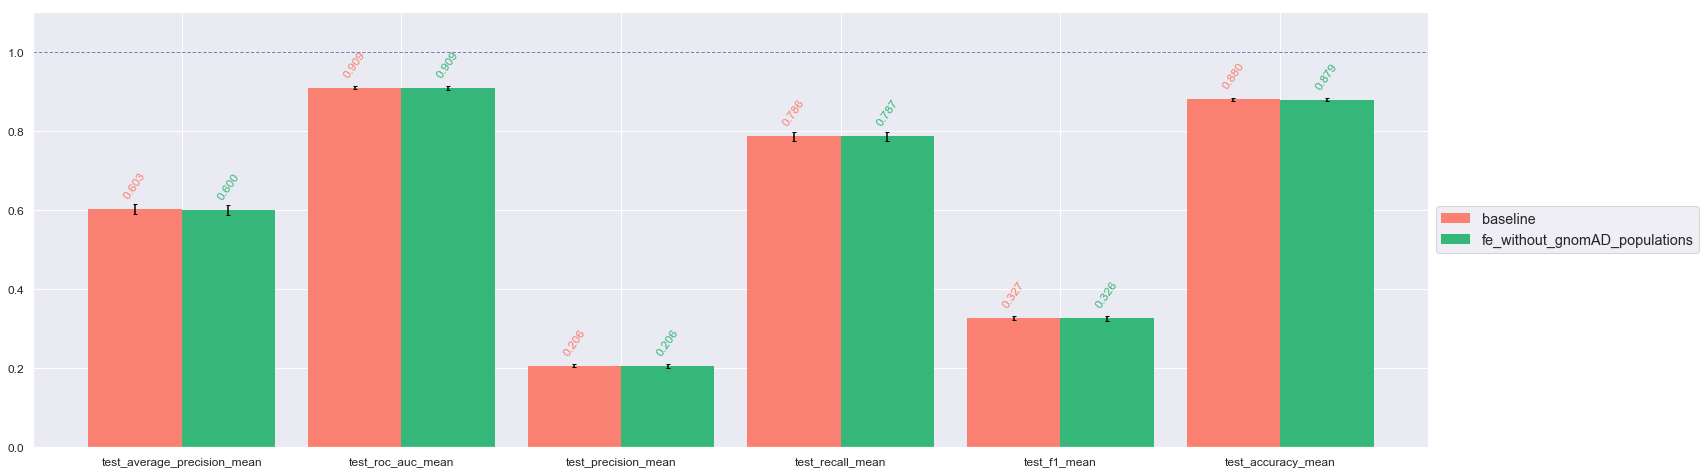

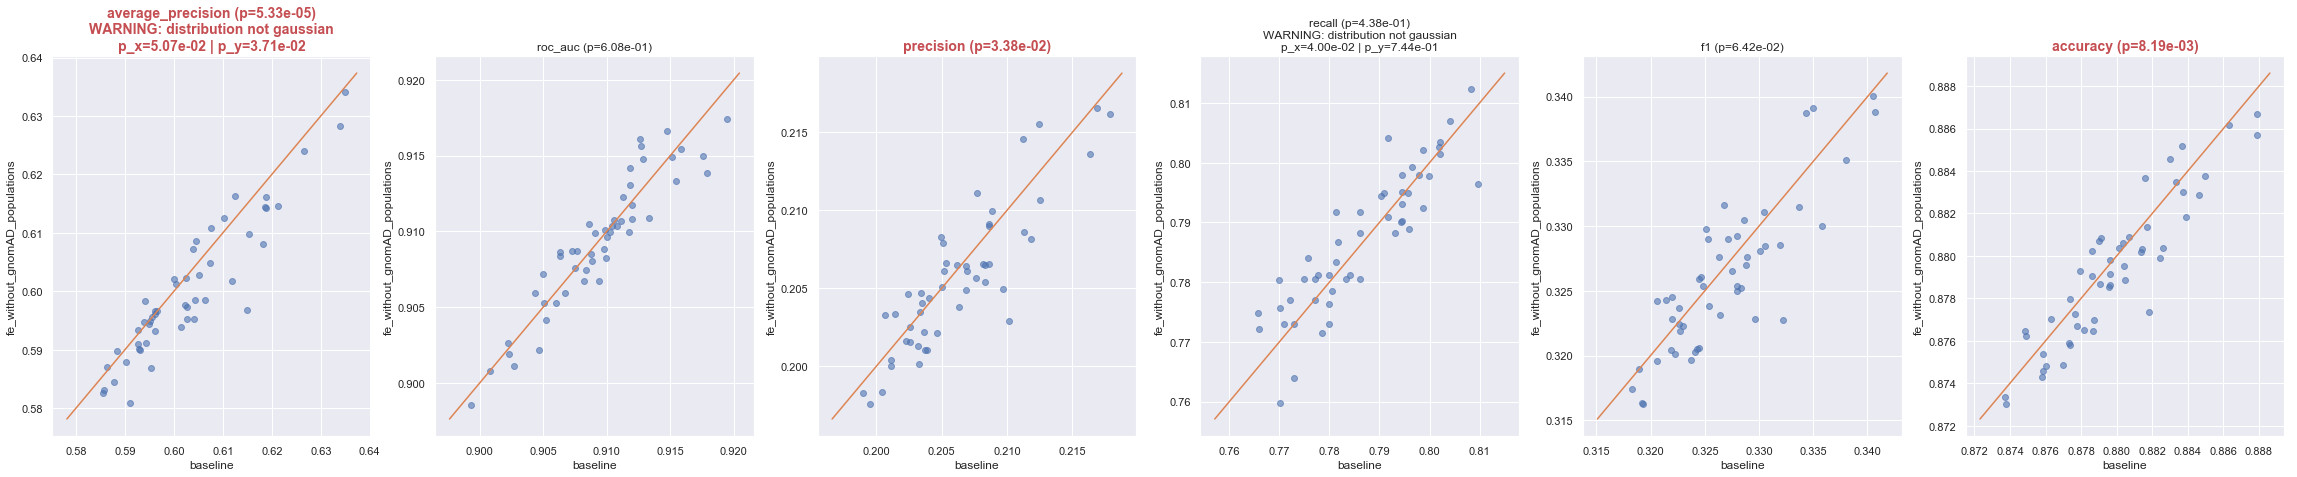

In [11]:
summary_2 = Summary()
summary_2.add(job_baseline.metrics, 'baseline', 'salmon')
summary_2.add(job.metrics, job.job_id)
summary_2.display()
summary_2.plot()
summary_2.plot_2_vs_2('baseline', 'fe_without_gnomAD_populations')

# Without `Kaviar_AF`

In [20]:
features = get_features(individual_features_to_remove = ['Kaviar_AF', 'VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_without_Kaviar_AF', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_baseline.script_path)

➞ mkdir on local computer ssh_remote_jobs/job_fe_without_Kaviar_AF


<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_without_Kaviar_AF


<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_without_Kaviar_AF


<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ script loaded

In [12]:
job = Selene_Job('fe_without_Kaviar_AF', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ job found and reloaded

In [22]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_fe_without_Kaviar_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_Kaviar_AF
script.ipy                                    100%  863   103.4KB/s   00:00    
X.pkl                                         100%   62MB  15.5MB/s   00:04    
y.pkl                                         100% 3225KB  10.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_Kaviar_AF
Job <30437832> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_Kaviar_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ submitted<br>

In [13]:
job.get_results()

<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_without_Kaviar_AF to ssh_remote_jobs/job_fe_without_Kaviar_AF
metrics.pkl                                   100%   64MB   8.9MB/s   00:07    
job_output.txt                                100% 1543   369.8KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.327,0.88
fe_without_Kaviar_AF,0.602,0.909,0.205,0.786,0.326,0.879


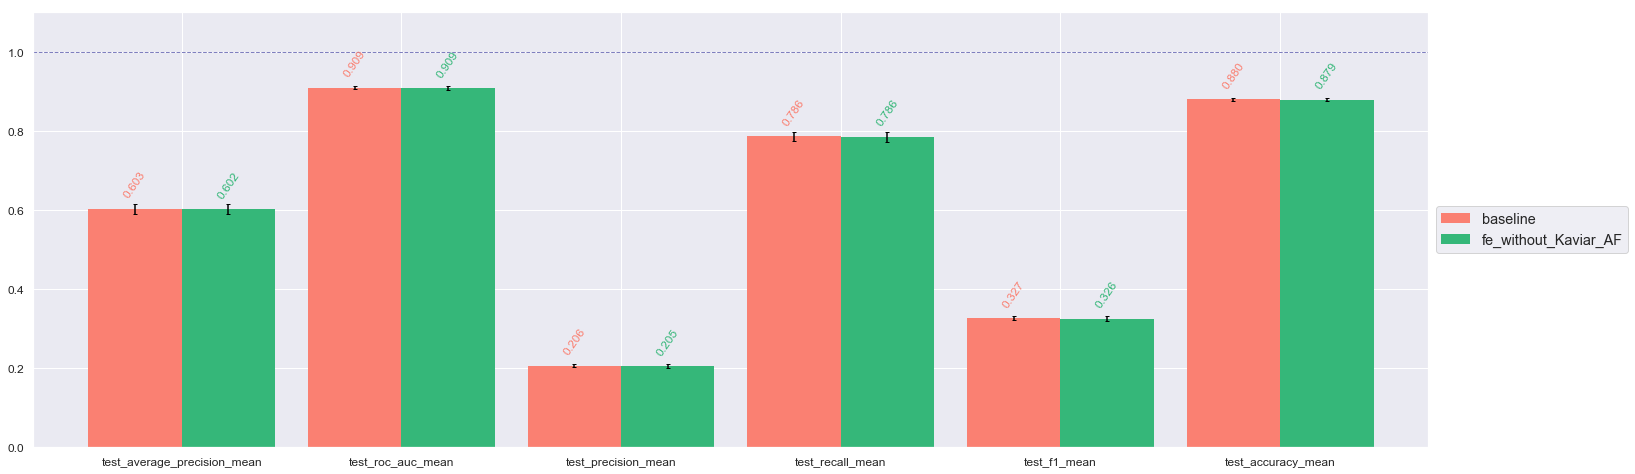

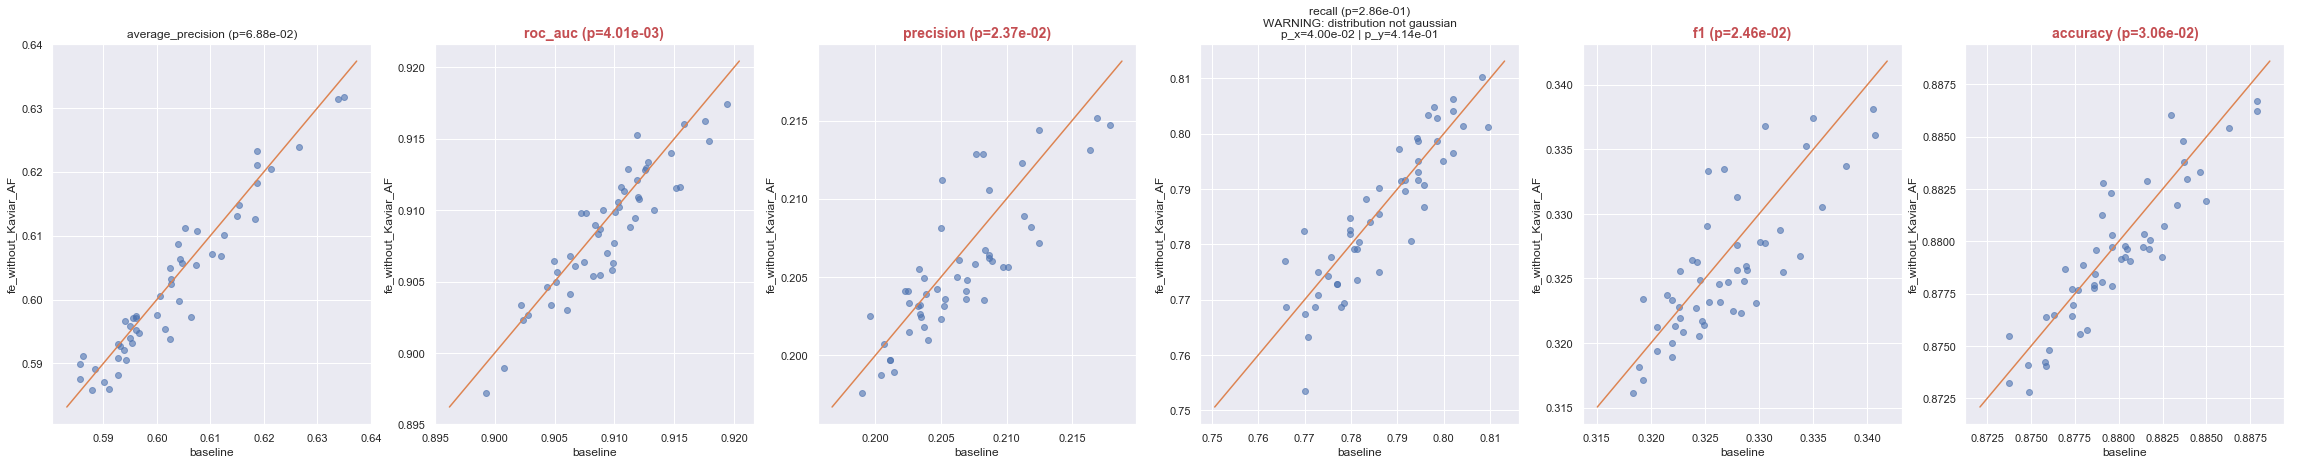

In [14]:
summary_3 = Summary()
summary_3.add(job_baseline.metrics, 'baseline', 'salmon')
summary_3.add(job.metrics, job.job_id)
summary_3.display()
summary_3.plot()
summary_3.plot_2_vs_2('baseline', job.job_id)

# New features

## Number of non-null gnomAD population

In [38]:
dd = data.impact.apply(lambda x: sum(x[AF_populations] != 0), axis=1)
get_table(dd)

,count_,freq_
0,154778,79.70%
1,21199,10.92%
2,7665,3.95%
3,4271,2.20%
4,2009,1.03%
7,1826,0.94%
6,1237,0.64%
5,1226,0.63%


In [39]:
data.add_features('VEP_gnomAD_non_null_population_number', dd, False)

In [40]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL']) + ['VEP_gnomAD_non_null_population_number']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_with_population_number', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_baseline.script_path)

➞ mkdir on local computer ssh_remote_jobs/job_fe_with_population_number


<span style="color:green">Job < fe_with_population_number >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_with_population_number


<span style="color:green">Job < fe_with_population_number >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_with_population_number


<span style="color:green">Job < fe_with_population_number >: </span>✅ script loaded

In [15]:
job = Selene_Job('fe_with_population_number', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_with_population_number >: </span>✅ job found and reloaded

In [42]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_fe_with_population_number to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_with_population_number
script.ipy                                    100%  863    85.4KB/s   00:00    
X.pkl                                         100%   65MB  13.6MB/s   00:04    
y.pkl                                         100% 3225KB  15.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_with_population_number
Job <30484674> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_with_population_number -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_with_population_number >: </span>✅ submitted<br>

In [16]:
job.get_results()

<span style="color:green">Job < fe_with_population_number >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_with_population_number to ssh_remote_jobs/job_fe_with_population_number
metrics.pkl                                   100%   64MB  10.0MB/s   00:06    
job_output.txt                                100% 1558   136.3KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.327,0.88
fe_with_population_number,0.603,0.909,0.206,0.786,0.326,0.88


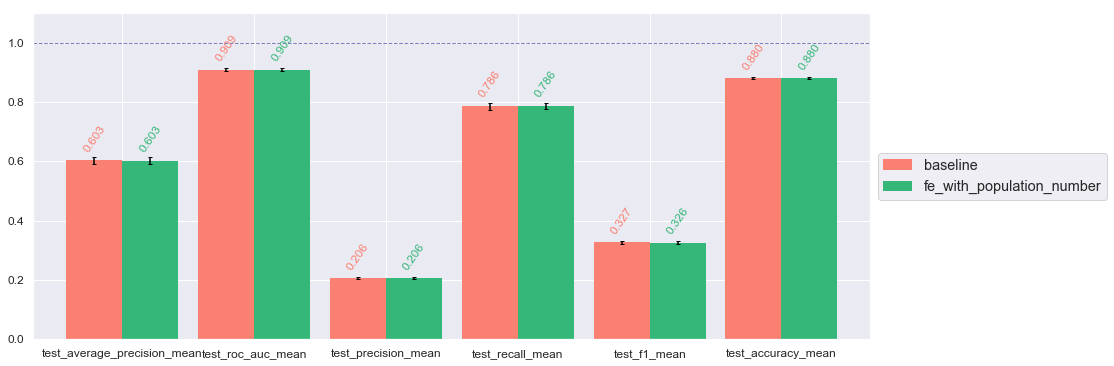

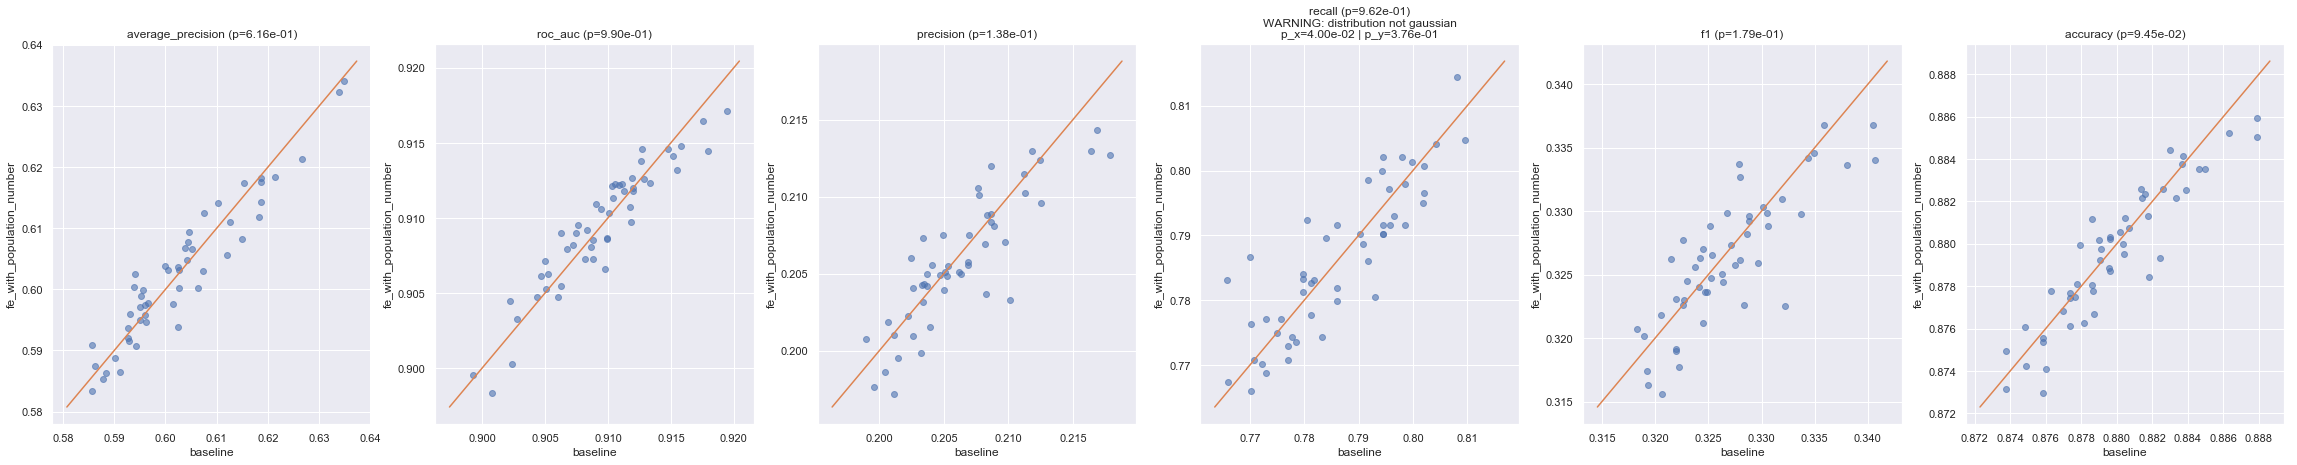

In [17]:
summary_4 = Summary()
summary_4.add(job_baseline.metrics, 'baseline', 'salmon')
summary_4.add(job.metrics, job.job_id)
summary_4.display()
summary_4.plot(figsize=(15, 6))
summary_4.plot_2_vs_2('baseline', job.job_id)

## Strand ratio

In [44]:
dd = data.impact[['t_alt_neg_count', 't_alt_plus_count']].min(axis=1) / data.impact[['t_alt_neg_count', 't_alt_plus_count']].max(axis=1)
dd.head()

0    0.853448
1    0.884615
2    0.825175
3    0.892857
4    0.886364
dtype: float64

In [45]:
data.add_features('strand_ratio', dd, False)

In [46]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL']) + ['strand_ratio']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_with_strand_ratio', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_baseline.script_path)

➞ mkdir on local computer ssh_remote_jobs/job_fe_with_strand_ratio


<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_with_strand_ratio


<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_with_strand_ratio


<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ script loaded

In [18]:
job = Selene_Job('fe_with_strand_ratio', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ job found and reloaded

In [48]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_fe_with_strand_ratio to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_with_strand_ratio
script.ipy                                    100%  863    58.0KB/s   00:00    
X.pkl                                         100%   65MB  13.9MB/s   00:04    
y.pkl                                         100% 3225KB   6.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_with_strand_ratio
Job <30484675> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_with_strand_ratio -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ submitted<br>

In [19]:
job.get_results()

<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_with_strand_ratio to ssh_remote_jobs/job_fe_with_strand_ratio
metrics.pkl                                   100%   64MB  10.2MB/s   00:06    
job_output.txt                                100% 1543   478.7KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.327,0.88
fe_with_strand_ratio,0.602,0.91,0.207,0.786,0.327,0.88


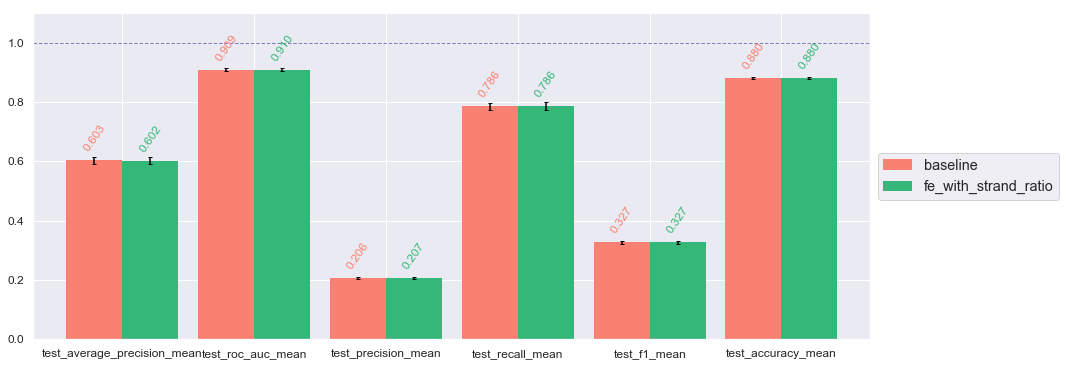

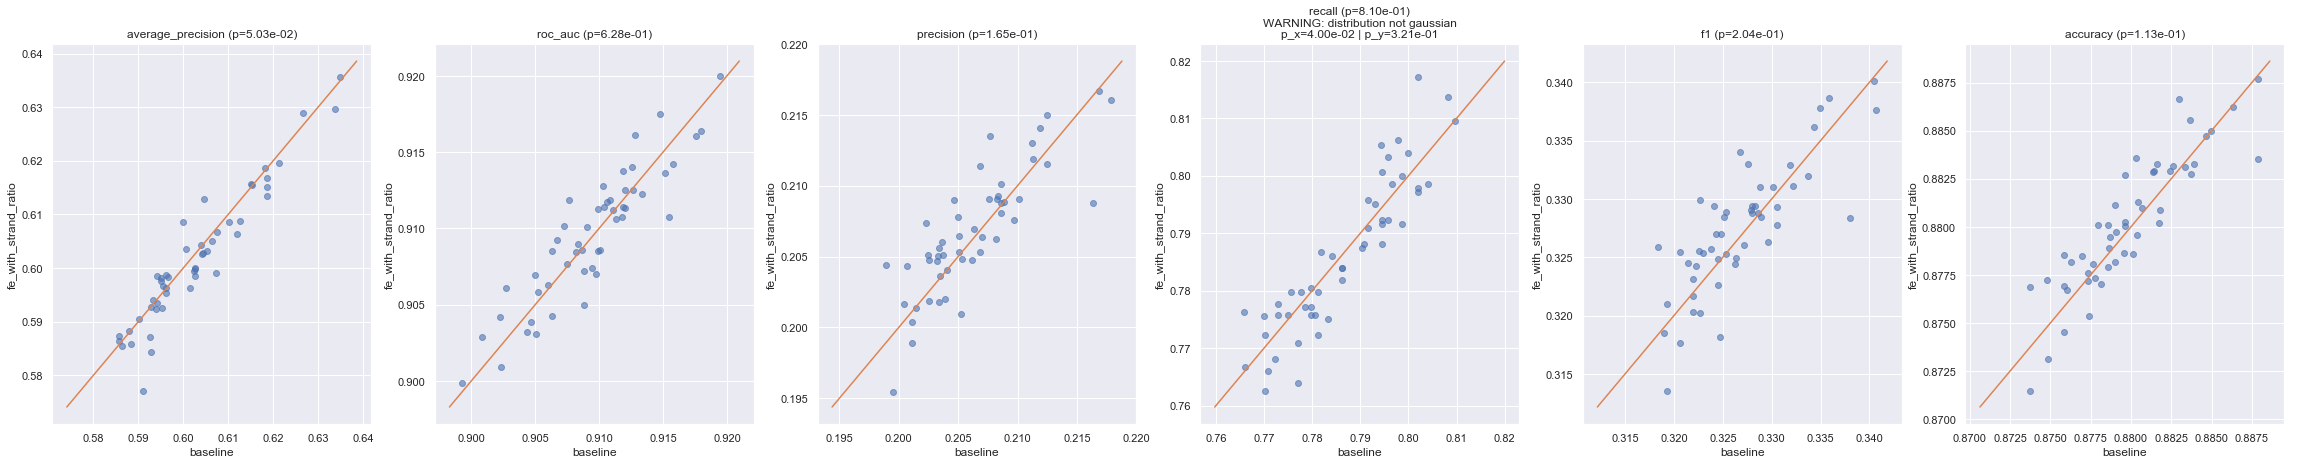

In [20]:
summary_5 = Summary()
summary_5.add(job_baseline.metrics, 'baseline', 'salmon')
summary_5.add(job.metrics, job.job_id)
summary_5.display()
summary_5.plot(figsize=(15, 6))
summary_5.plot_2_vs_2('baseline', job.job_id)

# VEP gnomAD_AF vs Pierre gnomAD_AF vs both

In [51]:
# VEP gnomAD_AF
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_total_AF', 'VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_1 = Selene_Job('fe_VEP_gnomAD_AF', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
job_1.load_data(X, y, path_to_script=job_baseline.script_path)


# Pierre gnomAD_AF
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_AF', 'VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_2 = Selene_Job('fe_Pierre_gnomAD_AF', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
job_2.load_data(X, y, path_to_script=job_baseline.script_path)


# without
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF', 'VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_3 = Selene_Job('fe_no_gnomAD_AF', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')
job_3.load_data(X, y, path_to_script=job_baseline.script_path)

➞ mkdir on local computer ssh_remote_jobs/job_fe_VEP_gnomAD_AF


<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_VEP_gnomAD_AF


<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_VEP_gnomAD_AF


<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ script loaded

➞ mkdir on local computer ssh_remote_jobs/job_fe_Pierre_gnomAD_AF


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_Pierre_gnomAD_AF


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_Pierre_gnomAD_AF


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ script loaded

➞ mkdir on local computer ssh_remote_jobs/job_fe_no_gnomAD_AF


<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_no_gnomAD_AF


<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_fe_baseline/script.ipy to ssh_remote_jobs/job_fe_no_gnomAD_AF


<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ script loaded

In [21]:
job_1 = Selene_Job('fe_VEP_gnomAD_AF'   , 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)
job_2 = Selene_Job('fe_Pierre_gnomAD_AF', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)
job_3 = Selene_Job('fe_no_gnomAD_AF'    , 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ job found and reloaded

In [53]:
job_1.run(n_jobs=20, short_job=True)
job_2.run(n_jobs=20, short_job=True)
job_3.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_fe_VEP_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_VEP_gnomAD_AF
script.ipy                                    100%  863    93.2KB/s   00:00    
X.pkl                                         100%   52MB  11.0MB/s   00:04    
y.pkl                                         100% 3225KB  13.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_VEP_gnomAD_AF
Job <30484677> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_VEP_gnomAD_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ submitted<br>

➞ scp ssh_remote_jobs/job_fe_Pierre_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_Pierre_gnomAD_AF
script.ipy                                    100%  863   107.7KB/s   00:00    
X.pkl                                         100%   52MB  13.7MB/s   00:03    
y.pkl                                         100% 3225KB  11.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_Pierre_gnomAD_AF
Job <30484678> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_Pierre_gnomAD_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ submitted<br>

➞ scp ssh_remote_jobs/job_fe_no_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_no_gnomAD_AF
script.ipy                                    100%  863   124.3KB/s   00:00    
X.pkl                                         100%   50MB  12.6MB/s   00:04    
y.pkl                                         100% 3225KB  12.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_no_gnomAD_AF
Job <30484679> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_no_gnomAD_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ submitted<br>

In [22]:
job_1.get_results()
job_2.get_results()
job_3.get_results()

<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_VEP_gnomAD_AF to ssh_remote_jobs/job_fe_VEP_gnomAD_AF
metrics.pkl                                   100%   64MB   9.5MB/s   00:06    
job_output.txt                                100% 1534   363.4KB/s   00:00    
➞ load metrics.pkl in object self.metrics


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_Pierre_gnomAD_AF to ssh_remote_jobs/job_fe_Pierre_gnomAD_AF
metrics.pkl                                   100%   64MB   9.3MB/s   00:06    
job_output.txt                                100% 1540   458.1KB/s   00:00    
➞ load metrics.pkl in object self.metrics


<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_fe_no_gnomAD_AF to ssh_remote_jobs/job_fe_no_gnomAD_AF
metrics.pkl                                   100%   64MB   9.0MB/s   00:07    
job_output.txt                                100% 1529   356.0KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.327,0.88
fe_VEP_gnomAD_AF,0.599,0.909,0.205,0.786,0.325,0.879
fe_Pierre_gnomAD_AF,0.601,0.909,0.206,0.786,0.326,0.88
fe_no_gnomAD_AF,0.599,0.909,0.204,0.786,0.324,0.878


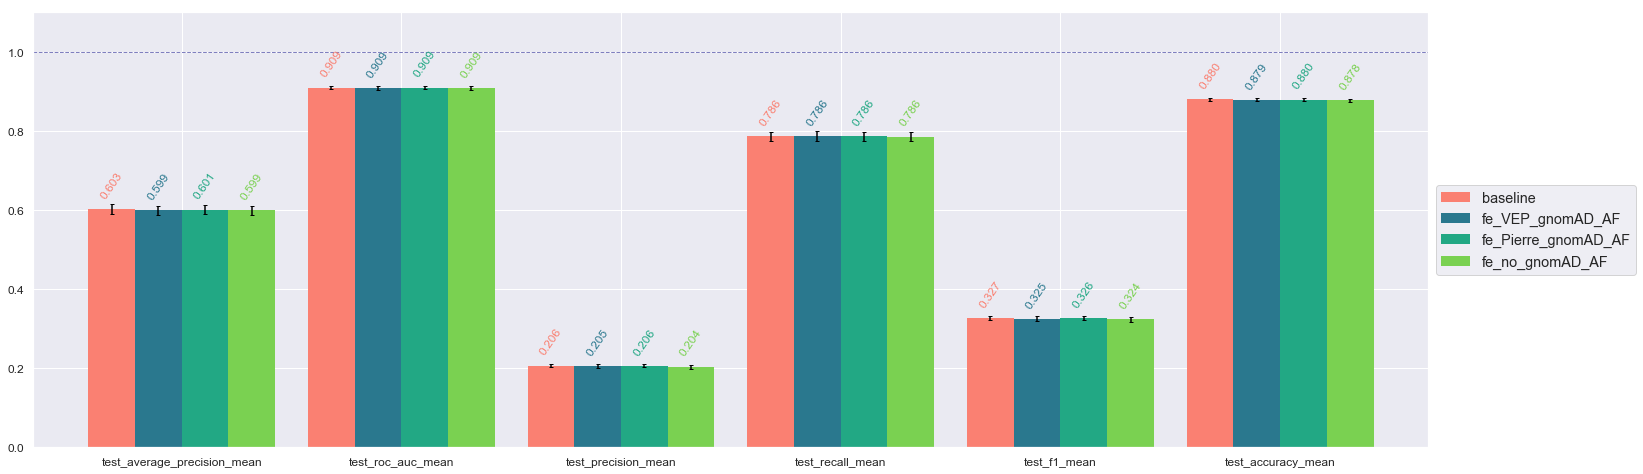

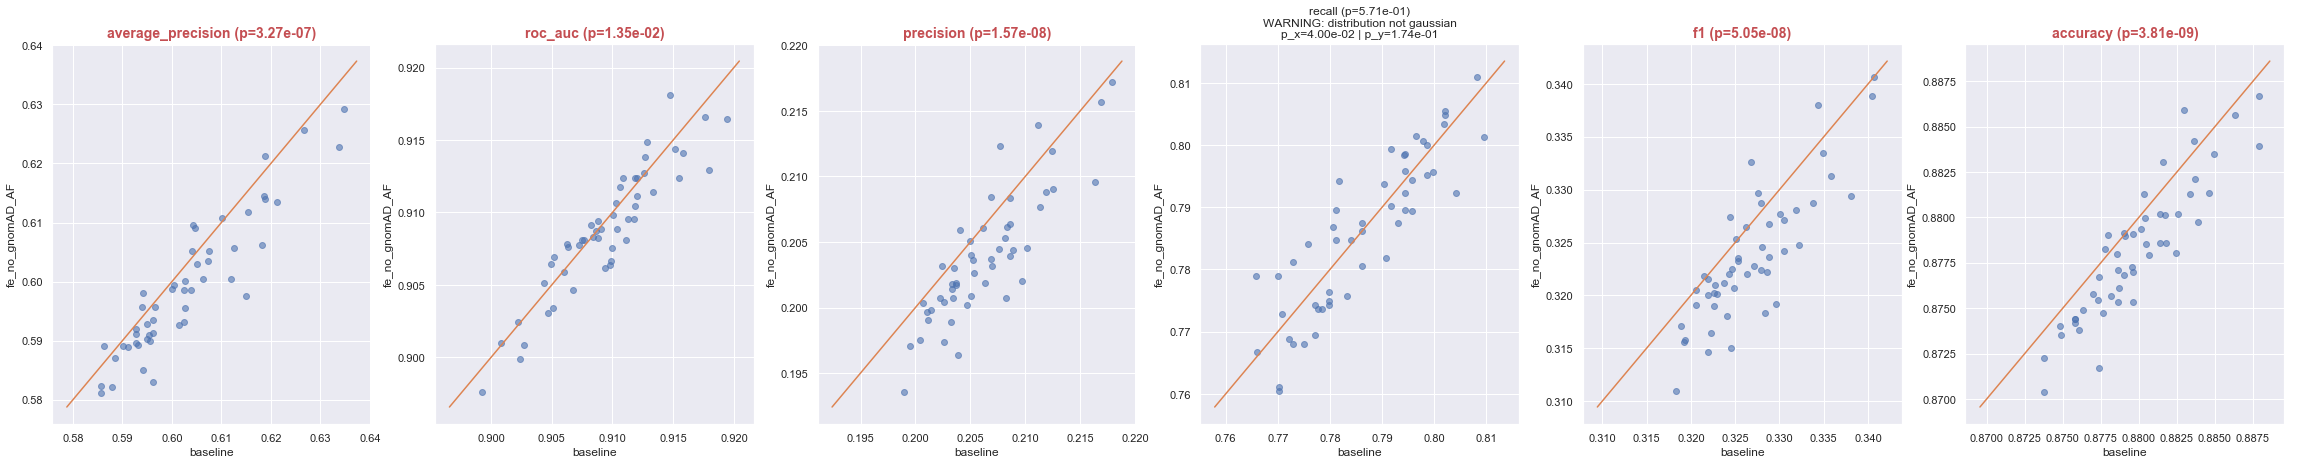

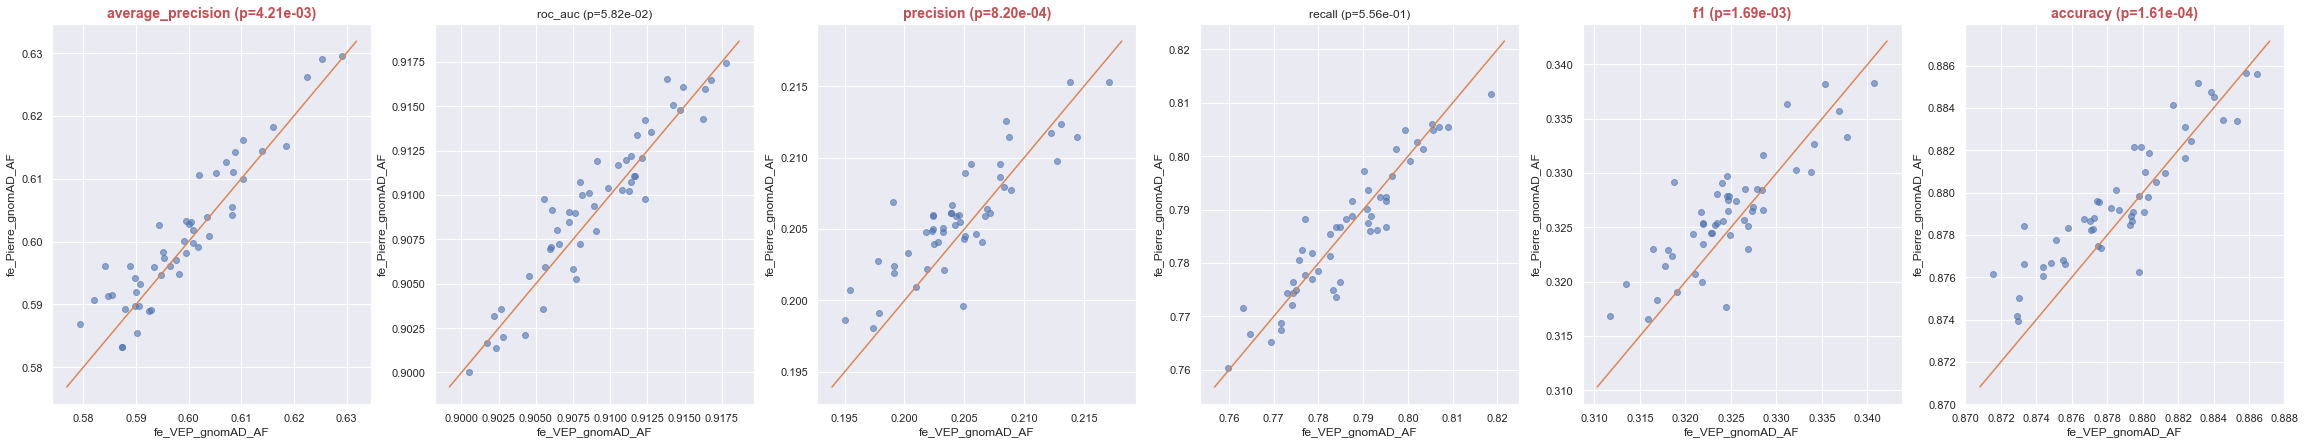

In [27]:
summary_6 = Summary()

summary_6.add(job_baseline.metrics, 'baseline', 'salmon')
summary_6.add(job_1.metrics, job_1.job_id)
summary_6.add(job_2.metrics, job_2.job_id)
summary_6.add(job_3.metrics, job_3.job_id)

summary_6.display()
summary_6.plot()
summary_6.plot_2_vs_2('baseline', job_3.job_id)
# summary_6.plot_2_vs_2('baseline', job_1.job_id)
# summary_6.plot_2_vs_2('baseline', job_2.job_id)
summary_6.plot_2_vs_2(job_1.job_id, job_2.job_id)